In [4]:
from bayes3d.dino import Dino
import bayes3d as b
import os
import torch
import numpy as np
import matplotlib
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torchvision.transforms as T


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vitg14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
dino = dinov2_vitg14.to(device)  # Same issue with larger model


feat_dim = 1536 # vitg14

def get_features(rgbd):
    img = b.get_rgb_image(rgbd.rgb).convert('RGB')
    patch_h, patch_w = np.array(img.size) // 14
    transform = T.Compose([
        T.GaussianBlur(9, sigma=(0.1, 2.0)),
        T.Resize((patch_h * 14, patch_w * 14)),
        T.CenterCrop((patch_h * 14, patch_w * 14)),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
    tensor = transform(img)[:3].unsqueeze(0).to(device)
    with torch.no_grad():
        features_dict = dinov2_vitg14.forward_features(tensor)
        features = features_dict['x_norm_patchtokens'][0].reshape((patch_h, patch_w, feat_dim)).permute(2, 0, 1).unsqueeze(0)
    print(features.shape)
    features = torch.nn.functional.interpolate(
        features, [img.height, img.width], mode="bilinear", align_corners=True
    )
    img_feat_norm = torch.nn.functional.normalize(features, dim=1)
    return jnp.array(img_feat_norm.cpu().detach().numpy())[0]


Using cache found in /home/nishadgothoskar/.cache/torch/hub/facebookresearch_dinov2_main


In [9]:
import bayes3d.ycb_loader

torch.Size([1, 1536, 45, 34])
torch.Size([1, 1536, 45, 34])


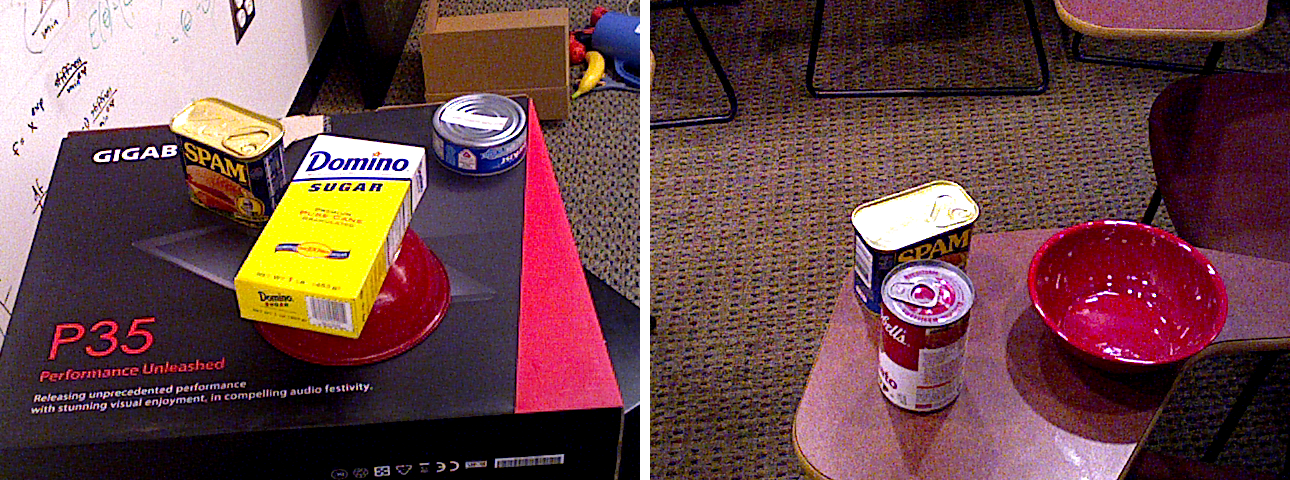

In [27]:
bop_ycb_dir = os.path.join(b.utils.get_assets_dir(), "bop/ycbv")
rgbd, gt_ids, gt_poses, masks = b.ycb_loader.get_test_img('49', '1', bop_ycb_dir)

embeddings = get_features(rgbd)

rgbd2, gt_ids2, gt_poses2, masks2 = b.ycb_loader.get_test_img('49', '1', bop_ycb_dir)
rgbd2, gt_ids2, gt_poses2, masks2 = b.ycb_loader.get_test_img('53', '1', bop_ycb_dir)
embeddings2 = get_features(rgbd2)

b.hstack_images([
    b.get_rgb_image(rgbd.rgb),
    b.get_rgb_image(rgbd2.rgb),
])

In [33]:
object_index = 2
mask = masks[object_index]
coords = jnp.vstack(jnp.where(mask))
key = jax.random.PRNGKey(10)

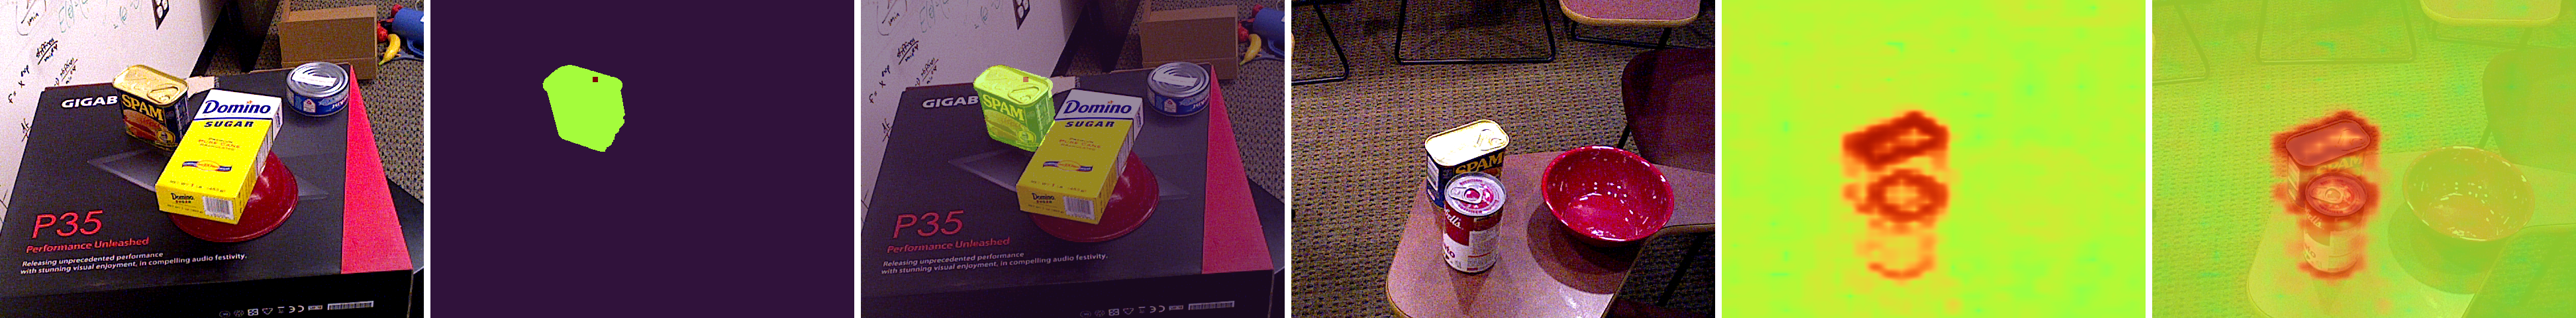

In [34]:

idx = jax.random.choice(key, coords.shape[1])
key = jax.random.split(key)[1]
ii,jj= coords[:,idx]
mask_ = 1.0 * mask
mask_ = mask_.at[ii-4:ii+4,jj-4:jj+4].set(2.0)
b.get_depth_image(mask_)
selected_embedding = embeddings[:,ii,jj]
similarity1 = jnp.einsum("iab, i->ab", embeddings, selected_embedding)
v1 = b.get_depth_image(similarity1, min=-1.0, max=1.0)
r1 = b.get_rgb_image(rgbd.rgb)

similarity2 = jnp.einsum("iab, i->ab", embeddings2, selected_embedding)
v2 = b.get_depth_image(similarity2, min=-1.0, max=1.0)
r2 = b.get_rgb_image(rgbd2.rgb)
b.hstack_images(
    [r1, b.get_depth_image(mask_), b.overlay_image(r1, b.get_depth_image(mask_)), r2,v2,b.overlay_image(r2,v2, alpha=0.8)]
)

In [24]:
selected_embedding.shape

(1536,)